In [1]:
import torch
import math

from torch import optim
from torch import Tensor
from torch.autograd import Variable
from torch import nn
from torch.nn import functional as F
import dlc_practical_prologue      
size=1000;
train_input, train_target, train_classes, test_input, test_target, test_classes = \
    dlc_practical_prologue.generate_pair_sets(size)
train_input, train_target, train_classes = Variable(train_input), Variable(train_target), Variable((train_classes))
test_input, test_target, test_classes = Variable(test_input), Variable(test_target), Variable(test_classes)
mini_batch_size = 10


C:\Users\antho\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\Users\antho\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
C:\Users\antho\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\Users\antho\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [2]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(test_input[i][0], cmap='gray', interpolation='none')
  plt.title("Value: {}".format(test_classes[i][0]))  
  plt.tight_layout()
  plt.xticks([])
  plt.yticks([])

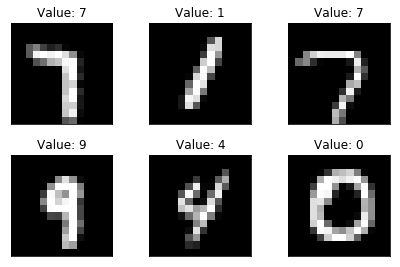

In [3]:
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(test_input[i][1], cmap='gray', interpolation='none')
  plt.title("Value: {}".format(test_classes[i][1]))  
  plt.tight_layout()
  plt.xticks([])
  plt.yticks([])

# First neural net
Train the model on all the 2000 images in train_input

In [4]:
my_train_input = train_input.reshape([2000,196])
my_train_classes = train_classes.reshape([2000])
my_test_input = test_input.reshape([2000,196])
my_test_classes = test_classes.reshape([2000])

In [48]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# number of epoch
num_epochs = 25
# batch size to compute mini-batch
batch_size = 5
# number of pixels in the image 
input_size = 196
# number of possible digit: 0 to 9 
num_class = 10
# small step to find a minima
learning_rate = 0.004
# hidden size
hidden_size = 200

# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_class):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, hidden_size)  
        self.layer3 = nn.Linear(hidden_size, num_class)  
    
    def forward(self, x):
        outputs = self.layer1(x)
        outputs = self.relu(outputs)
        outputs = self.layer2(outputs)
        outputs = self.relu(outputs)
        outputs = self.layer3(outputs)
        return outputs

# creating neural net
model = NeuralNet(input_size, hidden_size, num_class).to(device)

# CrossEntropyLoss and optimizer which minimize loss with learning rate step
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

In [49]:
def test_accuracy(model_, my_test_input_, my_test_classes_):
    total = my_test_input_.size(0)
    outputs = model_(my_test_input_)
    _, predictions = torch.max(outputs.data, 1)
    well_predicted_count = (predictions == my_test_classes_).sum().item()

    return 1 - well_predicted_count / total

In [50]:
def train_model(model_, my_train_input_, my_train_classes_, criterion_, optimizer_,num_epochs_,batch_size_):

    train_error = []
    test_error = []
    # train function
    for epoch in range(1, num_epochs_+1):
        for i in range(int(len(my_train_input_)/batch_size_)):  
            # Move tensors to the configured device
            images = my_train_input_.narrow(0,i*batch_size_,batch_size_).to(device)
            labels = my_train_classes_.narrow(0,i*batch_size_,batch_size_).to(device)

            # Forward pass
            outputs = model_(images)
            loss = criterion_(outputs, labels)

            # Backward and optimize
            optimizer_.zero_grad()
            loss.backward()
            optimizer_.step()

        train_error.append(test_accuracy(model_, my_train_input_, my_train_classes_))
        test_error.append(test_accuracy(model_, my_test_input, my_test_classes))
        if(epoch % 5 == 0 or epoch == 1):    
            print ('Loss: {:.4f} on epoch: {}, train error: {:.5f}, test error: {:.5f}'.format(loss.item(),epoch,train_error[-1],test_error[-1]))
    return train_error, test_error

train_error, test_error = train_model(model, my_train_input, my_train_classes, criterion, optimizer,num_epochs,batch_size)

Loss: 1.5856 on epoch: 1, train error: 0.13650, test error: 0.20150
Loss: 0.3290 on epoch: 5, train error: 0.02750, test error: 0.11650
Loss: 0.0171 on epoch: 10, train error: 0.00300, test error: 0.09250
Loss: 0.0005 on epoch: 15, train error: 0.00000, test error: 0.07900
Loss: 0.0004 on epoch: 20, train error: 0.00000, test error: 0.08000
Loss: 0.0003 on epoch: 25, train error: 0.00000, test error: 0.07950


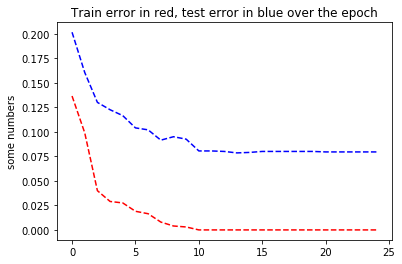

In [51]:
import matplotlib.pyplot as plt
plt.plot(train_error, 'r--', test_error, 'b--')
plt.ylabel('some numbers')
plt.title("Train error in red, test error in blue over the epoch")
plt.show()

# Let's try regularization: dropout

In [37]:
#as we got 100% on the train error it seems that we just leared by heart the train dataset
# let's adding regularization:
class NeuralNet_reg(nn.Module):
    def __init__(self, input_size, hidden_size, num_class):
        super(NeuralNet_reg, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, hidden_size)  
        self.layer3 = nn.Linear(hidden_size, hidden_size)  
        self.layer4 = nn.Linear(hidden_size, num_class)  
        self.dropout = nn.Dropout(0.8)
    
    def forward(self, x):
        outputs = self.layer1(x)
        outputs = self.relu(outputs)
        outputs = self.layer2(outputs)
        outputs = self.relu(outputs)
        outputs = self.layer3(outputs)
        outputs = self.relu(outputs)
        outputs = self.layer4(outputs)
        return outputs
# creating neural net
model_reg = NeuralNet_reg(input_size, hidden_size, num_class).to(device)

# CrossEntropyLoss and optimizer which minimize loss with learning rate step
criterion_reg = nn.CrossEntropyLoss()
optimizer_reg = torch.optim.SGD(model_reg.parameters(), lr=learning_rate) 

train_error, test_error = train_model(model_reg, my_train_input, my_train_classes, criterion_reg, optimizer_reg, num_epochs, batch_size)

Loss: 0.8557 on epoch: 1, train error: 0.11150, test error: 0.18200
Loss: 0.0120 on epoch: 5, train error: 0.00300, test error: 0.07950
Loss: 0.0056 on epoch: 10, train error: 0.00000, test error: 0.07250
Loss: 0.0033 on epoch: 15, train error: 0.00000, test error: 0.07150
Loss: 0.0022 on epoch: 20, train error: 0.00000, test error: 0.07150
Loss: 0.0016 on epoch: 25, train error: 0.00000, test error: 0.07150


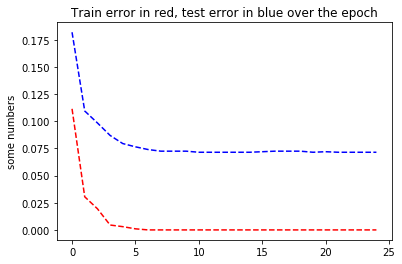

In [38]:
plt.plot(train_error, 'r--', test_error, 'b--')
plt.ylabel('some numbers')
plt.title("Train error in red, test error in blue over the epoch")
plt.show()

# Testing on the 2 batches
A model for the two batch of 1000 images

In [39]:
my_test_input1 = test_input[:,0,:]
my_test_input2 = test_input[:,1,:]
my_test_classes1 = test_classes[0:1000,0]
my_test_classes2 = test_classes[0:1000,1]

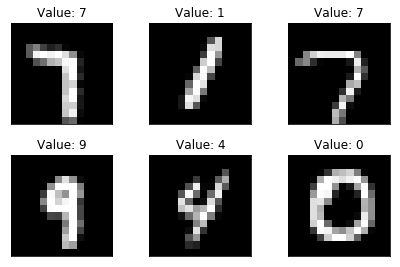

In [40]:
# verifying the digits and labels
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(my_test_input2[i], cmap='gray', interpolation='none')
  plt.title("Value: {}".format(my_test_classes2[i]))  
  plt.tight_layout()
  plt.xticks([])
  plt.yticks([])

In [41]:
my_test_input1=my_test_input1.reshape(1000,196)
my_test_input2=my_test_input2.reshape(1000,196)

In [42]:
print("Error on batch 1: {}".format(test_accuracy(model, my_test_input1, my_test_classes1)))
print("Error on batch 2: {}".format(test_accuracy(model, my_test_input2, my_test_classes2)))

Error on batch 1: 0.08299999999999996
Error on batch 2: 0.08599999999999997


# Building neural net for Digit Comparison

In [43]:
# number of epoch
num_epochs_dc = 21
# batch size to compute mini-batch
batch_size_dc = 10
# number of pixels in the image 
input_size_dc = 2
# number of possible digit: 0 to 9 
num_class_dc = 1
# small step to find a minima
learning_rate_dc = 0.004
# hidden size
hidden_size_dc = 200

# Fully connected neural network with one hidden layer
class NeuralNet_dc(nn.Module):
    def __init__(self, input_size, hidden_size, num_class):
        super(NeuralNet_dc, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, hidden_size)  
        self.layer3 = nn.Linear(hidden_size, num_class)  
    
    def forward(self, x, batch_size_):
        outputs = self.layer1(x)
        outputs = self.relu(outputs)
        outputs = self.layer2(outputs)
        outputs = self.relu(outputs)
        outputs = self.layer3(outputs)
        return outputs.reshape([1, batch_size_])[0]
        
    
# creating neural net
model_dc = NeuralNet_dc(input_size_dc, hidden_size_dc, num_class_dc).to(device)

# MSELoss and optimizer which minimize loss with learning rate step
criterion_dc = nn.MSELoss()
optimizer_dc = torch.optim.SGD(model_dc.parameters(), lr=learning_rate_dc)  

# train function
for epoch in range(num_epochs_dc):
    for i in range(int(len(train_classes)/batch_size_dc)):  
        # Move tensors to the configured device
        inputs = train_classes.narrow(0,i*batch_size_dc,batch_size_dc).to(device).float()
        labels = train_target.narrow(0,i*batch_size_dc,batch_size_dc).to(device)

        # Forward pass
        outputs = model_dc(inputs,batch_size_dc)
        loss = criterion_dc(outputs, labels.float())
        
        # Backward and optimize
        optimizer_dc.zero_grad()
        loss.backward()
        optimizer_dc.step()
    if(epoch % 5 == 0):    
        print ('Loss: {:.4f} on epoch: {}'.format(loss.item(),epoch+1))

Loss: 0.1127 on epoch: 1
Loss: 0.0278 on epoch: 6
Loss: 0.0171 on epoch: 11
Loss: 0.0134 on epoch: 16
Loss: 0.0110 on epoch: 21


In [44]:
# test function
def test_accuracy_dc(model_, my_test_input_, my_test_classes_):

    total = my_test_input_.size(0)

    outputs = model_(my_test_input_.float(),total)
    t = Variable(torch.Tensor([0.5]))
    predictions = (outputs > t).float() * 1

    well_predicted_count = (predictions == my_test_classes_.float()).sum().item()
    print('Accuracy: {} %'.format(100 * well_predicted_count / total))

test_accuracy_dc(model_dc, test_classes, test_target)


Accuracy: 100.0 %


# Running both neural networks in sequence

In [45]:
# test function
def getting_y(model_, my_test_input_, my_test_classes_):
    total = my_test_input_.size(0)
    outputs = model_(my_test_input_)
    _, predictions = torch.max(outputs.data, 1)
    well_predicted_count = (predictions == my_test_classes_).sum().item()

    print('Accuracy: {} %'.format(100 * well_predicted_count / total))
    return predictions

y1 = getting_y(model_reg, my_test_input1, my_test_classes1)
y2 = getting_y(model_reg, my_test_input2, my_test_classes2)
y_test_classes = torch.tensor([y1.tolist(), y2.tolist()]).transpose_(0, 1)
y_test_classes

Accuracy: 93.4 %
Accuracy: 92.3 %


tensor([[0, 7],
        [4, 1],
        [8, 7],
        ...,
        [5, 3],
        [5, 6],
        [7, 4]])

In [46]:
# test function
def digit_comparison(model_, my_test_input_, my_test_classes_):
    total = my_test_input_.size(0)

    outputs = model_(my_test_input_.float())
    t = Variable(torch.Tensor([0.5]))
    predictions = (outputs > t).float() * 1

    well_predicted_count = (predictions == my_test_classes_.float()).sum().item()
    print('Accuracy: {} %'.format(100 * well_predicted_count / total))

test_accuracy_dc(model_dc, y_test_classes, test_target)

Accuracy: 95.4 %
